In [1]:
library(dplyr)
library(ggplot2)
library(stringr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# **scatter plot and compare all tissue coefs**

In [3]:
tmp_file_path = "../../../"

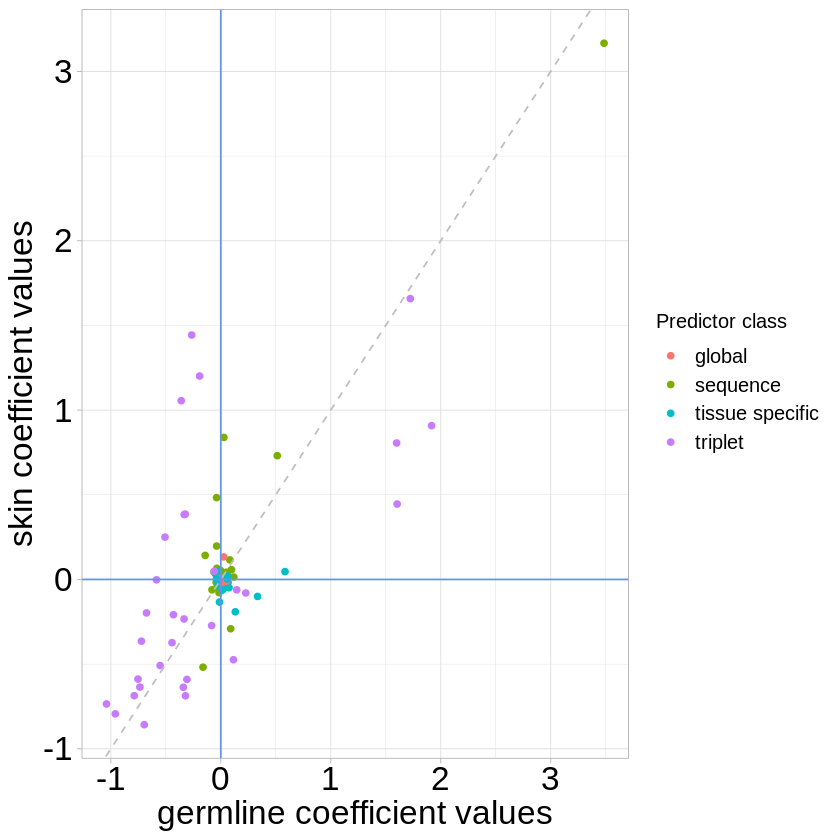

In [7]:

# args = commandArgs(trailingOnly=TRUE)
# tissue = args[1]
# tissue_predOn = args[2]
# model_name = args[3]
tissue = "skin"
tissue_predOn = "germline"
model_name = "model2"


#reading in data
tissue_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_coefDF.csv",sep=""))
tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"data/",tissue_predOn,"/dataframes/",model_name,"/",tissue_predOn,"_coefDF.csv",sep=""))

#isolating only the column with the coeficient values 
tissue_coefs <- tissue_coefs[,c("name","coefficient")]
tissue_predOn_coefs <- tissue_predOn_coefs[,c("name","coefficient")]

#renaming 
colnames(tissue_coefs) <- c("name","tissue_coefs")
colnames(tissue_predOn_coefs) <- c("name","tissue_predOn_coefs")

#ordering by name so the mathcing works 
tissue_coefs_ordered <- tissue_coefs[order(tissue_coefs$name),] #https://www.statmethods.net/management/sorting.html
tissue_predOn_coefs_ordered <- tissue_predOn_coefs[order(tissue_predOn_coefs$name),]

#merge on name column 
all_coefs <-merge(tissue_coefs_ordered,tissue_predOn_coefs_ordered,by="name")

#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        
        str_detect(name, 'triplet') ~ 'triplet',
        
        str_detect(name, 'DNAse') ~ 'tissue specific',
        str_detect(name, 'Transcription') ~ 'tissue specific',
        str_detect(name, 'H3k') ~ 'tissue specific',
        
        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
    ))

#plotting
ggplot(all_coefs, aes(y = tissue_coefs, x = tissue_predOn_coefs)) +
    geom_point(aes(color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )   
# ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,".pdf",sep=""))


#writing some infor on how wel they match to file 
error_output_file = paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_textOutput.txt",sep="")

MAE = mean(abs(all_coefs$tissue_coefs - all_coefs$tissue_predOn_coefs))
string_to_print = paste("mean absolute error is",round(MAE,4),sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

fit<-lm(tissue_coefs~tissue_predOn_coefs,data=all_coefs)
string_to_print = paste("r-squared is",summary(fit)$r.squared,sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)


# **get the fold coomp plot**

In [8]:
all_coefs <- all_coefs %>% 
    mutate(fold_change = tissue_coefs/tissue_predOn_coefs)  

all_ceofs <- all_coefs[order(all_coefs$fold_change),] 

head_all_coefs <- head(all_ceofs,n=10)
tail_all_coefs <- tail(all_ceofs,n=10)
fold_plotting <- rbind(head_all_coefs,tail_all_coefs)

posNeg_log10 <- function(number) {
    if (number > 0) {
         return(log10(number))
    } else {
         return(-log10(-number))
    }
}
fold_plotting$log10_chnage <- as.numeric(lapply(fold_plotting$fold_change, posNeg_log10))



Saving 6.67 x 6.67 in image



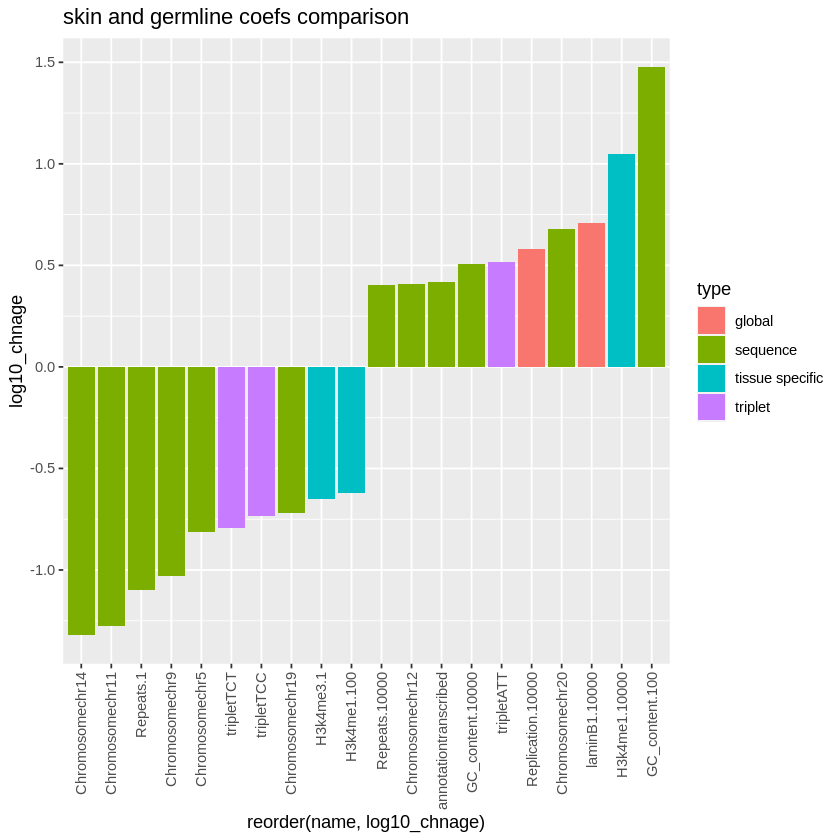

In [9]:
ggplot(data=fold_plotting,aes(x=reorder(name,log10_chnage),y=log10_chnage))+
    geom_bar(stat="identity",aes(fill=type))+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+#https://stackoverflow.com/questions/1330989/rotating-and-spacing-axis-labels-in-ggplot2
    ggtitle(paste(tissue,"and",tissue_predOn,"coefs comparison",sep=" "))
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefFoldChange_",tissue,"_on_",tissue_predOn,".pdf",sep=""))